In [1]:
import sinkhorn_knopp as sk
import utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0-dev20191111'

Create sample feature vectors fa and fb and compute augmented Sij matrix

In [3]:
Sij_aug, a_vec, b_vec, pos_mask, neg_mask, dustbin_mask, neg_scores_mask = utils.sample_random_scores_matrix()

In [4]:
# Eq. (9)
a_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 5.])

In [5]:
b_vec

array([ 1.,  1.,  1.,  1.,  1., 13.])

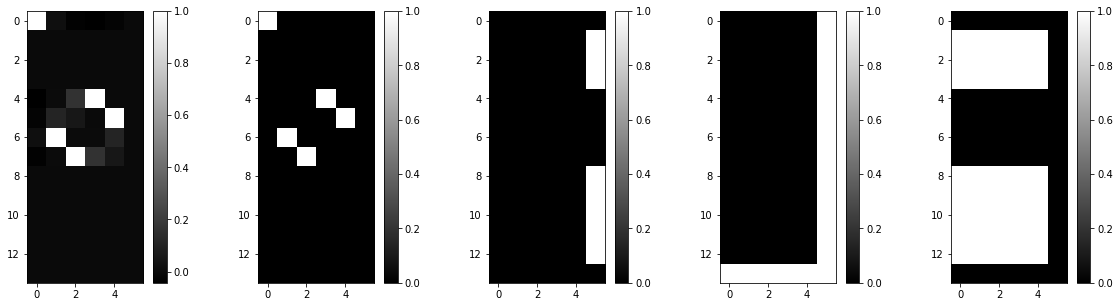

In [6]:
utils.plot_matrices([Sij_aug, pos_mask, neg_mask, dustbin_mask, neg_scores_mask])

Compute optimal transport using Sinkhorn-Knopp iterative algorithm

In [7]:
Pij, distance =  sk.compute_optimal_transport(- Sij_aug, a_vec, b_vec, 10)

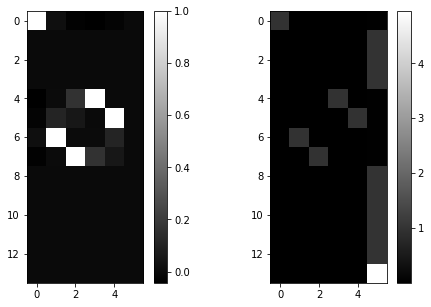

In [8]:
utils.plot_matrices([Sij_aug, Pij])

# Simulate training process

Lambda parameter i.e. strength of the entropic regularization 

In [9]:
def sinkhorn_step(Pij: tf.Tensor, a_vec: tf.Tensor, b_vec: tf.Tensor) -> tf.Tensor:        
    u = tf.reshape(a_vec / tf.reduce_sum(Pij, axis=1), [-1, 1])
    Pij = Pij * u
    v = tf.reshape(b_vec / tf.reduce_sum(Pij, axis=0), [1, -1])        
    Pij = Pij * v
    return Pij


def compute_loss_per_step(dustbin_var, neg_score_var, lam: float):    
    Sij_aug, a_vec, b_vec, pos_mask, neg_mask, dustbin_mask, neg_scores_mask = utils.sample_random_scores_matrix()
    with tf.GradientTape() as tape:
        # compute final cost matrix 
        Sij_aug_final = - (Sij_aug + dustbin_mask * dustbin_var + neg_scores_mask * neg_score_var)
        
        # solve optimal transport using python solver to find good initial conditions
        # for the graph based approach. 
        Sij_aug_np = Sij_aug_final.numpy()    
        Pij_np, _ = sk.compute_optimal_transport(Sij_aug_np, a_vec, b_vec, lam=lam)

        # estimate good initial conditions to be used in the graph approach, so we will
        # need only one iteration to reach convergence 
        alpha_beta = Pij_np * np.exp(lam * Sij_aug_np)
        
        Pij_0 = alpha_beta * tf.exp(- lam * Sij_aug_final)
        Pij_0 = Pij_0 / tf.reduce_sum(Pij_0)        
        Pij = sinkhorn_step(Pij_0, a_vec, b_vec)

        # Loss from Eq (10)
        loss = tf.math.log(tf.clip_by_value(Pij, 1e-6, 1.0)) * (pos_mask + neg_mask)        
        loss = - tf.reduce_sum(loss)
        
        grads = tape.gradient(loss, [dustbin_var, neg_score_var])
    return Pij, loss, grads

# Start simulation with bad initial conditions
I want to see if disbin and score variables will converge to optimal values  

In [10]:
lam = 5
dustbin_var = tf.Variable(0.0)
neg_score_var = tf.Variable(1.5)
variables = [dustbin_var, neg_score_var]
optimizer = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9)

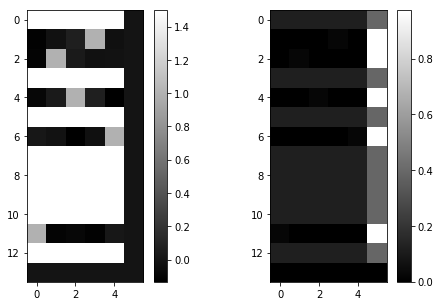

In [11]:
Sij_aug, a_vec, b_vec, pos_mask, neg_mask, dustbin_mask, neg_scores_mask = utils.sample_random_scores_matrix()
Sij_aug_final = - (Sij_aug + dustbin_mask * dustbin_var + neg_scores_mask * neg_score_var)
Pij, _ = sk.compute_optimal_transport(Sij_aug_final.numpy(), a_vec, b_vec, lam=lam)
Pij[-1, -1] = 0
utils.plot_matrices([- Sij_aug_final, Pij])

In [12]:
loss_history = []
dustbin_var_history = []
neg_score_history = []

In [13]:
for i in range(100):    
    Pij, loss, grads = compute_loss_per_step(dustbin_var, neg_score_var, lam = lam)
    optimizer.apply_gradients(zip(grads, variables))
    loss_history.append(loss.numpy())
    dustbin_var_history.append(dustbin_var.numpy())
    neg_score_history.append(neg_score_var.numpy())

In [14]:
grads

[<tf.Tensor: shape=(), dtype=float32, numpy=4.913658e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.9829654e-08>]

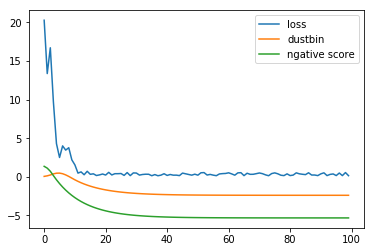

In [15]:
plt.plot(loss_history, label="loss")
plt.plot(dustbin_var_history, label="dustbin")
plt.plot(neg_score_history, label="ngative score")
plt.legend()

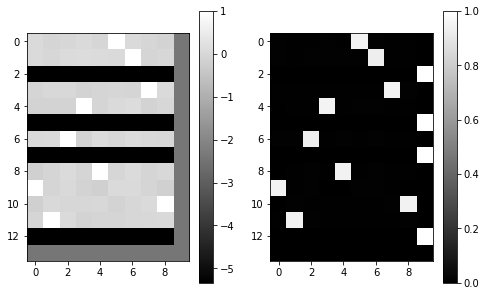

In [16]:
Sij_aug, a_vec, b_vec, pos_mask, neg_mask, dustbin_mask, neg_scores_mask = utils.sample_random_scores_matrix()
Sij_aug_final = - (Sij_aug + dustbin_mask * dustbin_var + neg_scores_mask * neg_score_var)
Pij, _ = sk.compute_optimal_transport(Sij_aug_final.numpy(), a_vec, b_vec, lam=lam)
Pij[-1, -1] = 0
utils.plot_matrices([- Sij_aug_final, Pij])

# Training without distbin optimization (only negative score is optimizer)

In [17]:
dustbin_var = tf.Variable(0.0)
neg_score_var = tf.Variable(1.5)
variables = [neg_score_var]
optimizer = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [18]:
loss_history_no_dustbin = []
for i in range(100):    
    Pij, loss, grads = compute_loss_per_step(dustbin_var, neg_score_var, lam = lam)
    optimizer.apply_gradients(zip(grads, variables))
    loss_history_no_dustbin.append(loss.numpy())

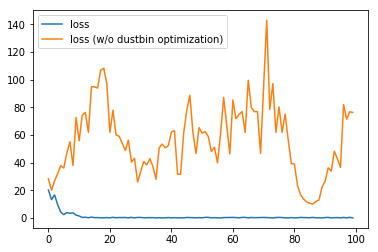

In [19]:
plt.plot(loss_history, label="loss")
plt.plot(loss_history_no_dustbin, label="loss (w/o dustbin optimization)")
plt.legend()

# Training without negative score optimization

In [20]:
dustbin_var = tf.Variable(0.0)
neg_score_var = tf.Variable(1.5)
variables = [dustbin_var]
optimizer = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [21]:
loss_history_no_neg_score = []
for i in range(100):    
    Pij, loss, grads = compute_loss_per_step(dustbin_var, neg_score_var, lam = lam)
    optimizer.apply_gradients(zip(grads, variables))
    loss_history_no_neg_score.append(loss.numpy())

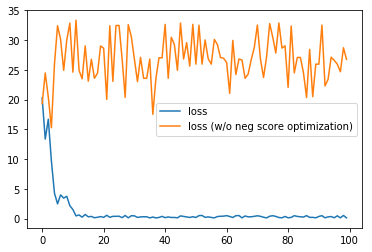

In [22]:
plt.plot(loss_history, label="loss")
plt.plot(loss_history_no_neg_score, label="loss (w/o neg score optimization)")
plt.legend()